In [63]:
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns

### replicate a few plots

In [155]:
new_df = pd.read_csv('./devraj2022rational.csv')
new_df = new_df[new_df.condition=='control']

In [159]:
# plot accuracy of choice for each participant over trial segments using new dataframe
accuracy = []
for participant_id in new_df.participant.unique():
    new_df_participant = new_df[new_df.participant==participant_id]
    participant_acc = []
    for trial_segment in new_df_participant.trial_segment.unique():
        new_df_participant_trial_segment = new_df_participant[new_df_participant.trial_segment==trial_segment]
        participant_acc.append(np.sum(new_df_participant_trial_segment.choice.values==new_df_participant_trial_segment.correct_choice.values)/len(new_df_participant_trial_segment))
    accuracy.append(participant_acc)

<AxesSubplot:>

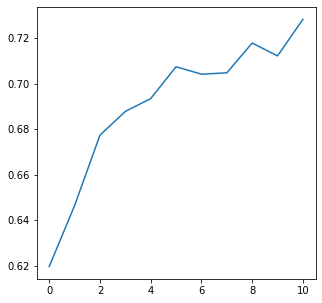

In [160]:
# plot mean accuracy of participants over trial segments as line plot
f, ax = plt.subplots(1, 1, figsize=(5,5))
sns.lineplot(x=np.arange(11), y=np.mean(accuracy, axis=0), ax=ax)

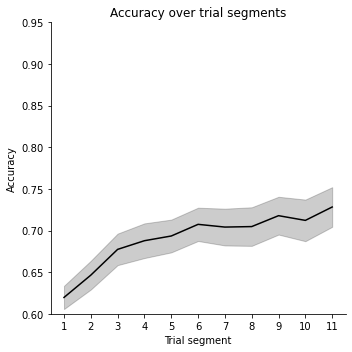

In [167]:

# plot mean accuracy of participants over trial segments as line plot
f, ax = plt.subplots(1, 1, figsize=(5,5))
sns.lineplot(x=np.arange(11), y=np.mean(accuracy, axis=0), ax=ax, color='k')
# add standard error of mean as error bars
ax.fill_between(np.arange(11), np.mean(accuracy, axis=0)-np.std(accuracy, axis=0)/np.sqrt(len(accuracy)), np.mean(accuracy, axis=0)+np.std(accuracy, axis=0)/np.sqrt(len(accuracy)), color='k', alpha=0.2)
ax.set_ylim([0.6, .95])
ax.set_xlabel('Trial segment')
ax.set_ylabel('Accuracy')
ax.set_xticks(np.arange(11))
ax.set_xticklabels(np.arange(11)+1)
ax.set_title('Accuracy over trial segments')
sns.despine()
f.tight_layout()
plt.show()

### compile and preprocess data

In [139]:
# load csv file but ingore first row as header
experiment_1 = pd.read_csv('./experiment1.csv', header=None)
experiment_1 = experiment_1.rename(columns={0: 'stimulus_sequence'}) # name first column as stimulus sequence

# extract the stimulus sequence for each participant
stimulus_sequence, choices, true_categories, conditions = [], [], [], []
for stim_seq_id in experiment_1.stimulus_sequence.values:
    participant_choices = experiment_1[experiment_1.stimulus_sequence==stim_seq_id].values.squeeze()[1:]
    stimuli = pd.read_csv(f'./stimuli/stim_list_{stim_seq_id}.csv', header=None).values.squeeze()
    participant_true_categories = np.zeros_like(stimuli) + 1
    participant_true_categories[stimuli>=7] = 2
    stimulus_sequence.append(stimuli)
    choices.append(participant_choices)
    true_categories.append(participant_true_categories)
    conditions.append('control' if stim_seq_id%2==0 else 'experimental')

#stimuli 0 to 6: [000000, 100000, 010000, 001000, 000010, 000001, 111101] and 7 to 13: [111111, 011111, 101111, 110111, 111011, 111110, 000010]
stimulus_features = {0: [0, 0, 0, 0, 0, 0], 1: [1, 0, 0, 0, 0, 0], 2: [0, 1, 0, 0, 0, 0], 3: [0, 0, 1, 0, 0, 0], \
                     4: [0, 0, 0, 0, 1, 0], 5: [0, 0, 0, 0, 0, 1], 6: [1, 1, 1, 1, 0, 1], 7: [1, 1, 1, 1, 1, 1], \
                     8: [0, 1, 1, 1, 1, 1], 9: [1, 0, 1, 1, 1, 1], 10: [1, 1, 0, 1, 1, 1], 11: [1, 1, 1, 0, 1, 1],\
                    12: [1, 1, 1, 1, 1, 0], 13: [0, 0, 0, 0, 1, 0]}
                     
# make a new dataframe with each row containing features of the task of one trial for a given participant
new_df = pd.DataFrame(columns=['participant', 'task', 'trial', 'choice', 'correct_choice', 'block', 'trial_segment', 'condition', 'category', 'all_features', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6'])
for participant_id in range(2):
    for trial_id in range(len(stimulus_sequence[participant_id])):
        block_id = trial_id//14
        trial_segment = trial_id//56
        new_df = new_df.append(pd.DataFrame({'participant': [participant_id], 'task': [0], 'block': [block_id], 'trial_segment': [trial_segment], 'condition': [conditions[participant_id]], \
                                             'trial': [trial_id], 'category': [true_categories[participant_id][trial_id]], 'choice': [choices[participant_id][trial_id]], \
                                             'correct_choice': [true_categories[participant_id][trial_id]], 'all_features': [str(stimulus_features[stimulus_sequence[participant_id][trial_id]])], \
                                             'feature1': [stimulus_features[stimulus_sequence[participant_id][trial_id]][0]], 'feature2': [stimulus_features[stimulus_sequence[participant_id][trial_id]][1]], \
                                             'feature3': [stimulus_features[stimulus_sequence[participant_id][trial_id]][2]], 'feature4': [stimulus_features[stimulus_sequence[participant_id][trial_id]][3]], \
                                             'feature5': [stimulus_features[stimulus_sequence[participant_id][trial_id]][4]], 'feature6': [stimulus_features[stimulus_sequence[participant_id][trial_id]][5]]}), ignore_index=True)

In [140]:
new_df

,participant,task,trial,choice,correct_choice,block,trial_segment,condition,category,all_features,feature1,feature2,feature3,feature4,feature5,feature6
0,0,0,0,2,1,0,0,control,1,"[1, 0, 0, 0, 0, 0]",1,0,0,0,0,0
1,0,0,1,2,1,0,0,control,1,"[0, 1, 0, 0, 0, 0]",0,1,0,0,0,0
2,0,0,2,1,1,0,0,control,1,"[0, 0, 0, 0, 0, 1]",0,0,0,0,0,1
3,0,0,3,1,2,0,0,control,2,"[1, 1, 0, 1, 1, 1]",1,1,0,1,1,1
4,0,0,4,2,1,0,0,control,1,"[1, 1, 1, 1, 0, 1]",1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,1,0,611,1,2,43,10,control,2,"[1, 1, 1, 1, 1, 1]",1,1,1,1,1,1
1228,1,0,612,1,1,43,10,control,1,"[0, 1, 0, 0, 0, 0]",0,1,0,0,0,0
1229,1,0,613,2,2,43,10,control,2,"[0, 1, 1, 1, 1, 1]",0,1,1,1,1,1
1230,1,0,614,2,2,43,10,control,2,"[1, 0, 1, 1, 1, 1]",1,0,1,1,1,1


In [8]:
experiment_1 = pd.read_csv('./experiment1.csv',header=None)

In [10]:
experiment_1 = experiment_1.rename(columns={0: 'stimulus_sequence'})

In [83]:
experiment_1

,stimulus_sequence,1,2,3,4,5,6,7,8,9,...,607,608,609,610,611,612,613,614,615,616
0,102,2,2,1,1,2,1,1,2,1,...,2,1,1,1,1,2,2,1,2,1
1,106,1,1,2,2,1,1,1,1,2,...,2,1,2,1,2,1,1,2,2,2
2,204,1,2,1,1,2,2,1,1,2,...,2,2,2,2,1,1,2,1,2,1
3,132,1,1,2,1,1,2,1,1,2,...,2,2,2,1,1,1,2,2,1,1
4,190,1,1,1,1,1,2,1,2,2,...,1,1,2,2,2,2,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,231,1,2,1,1,1,1,1,1,1,...,2,2,1,2,1,2,1,2,1,1
116,235,1,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
117,237,1,2,1,1,1,1,1,1,1,...,1,2,1,1,1,1,1,1,1,2
118,241,1,2,2,2,2,2,2,2,2,...,1,1,1,2,1,1,1,2,1,1


In [115]:
stim_seq_id = 140

In [116]:
choices = experiment_1[experiment_1.stimulus_sequence==stim_seq_id].values.squeeze()[1:]
stimuli = pd.read_csv(f'./stimuli/stim_list_{stim_seq_id}.csv', header=None).values.squeeze()
true_categories = np.zeros_like(stimuli) + 1
true_categories[stimuli>=7] = 2

In [117]:
true_categories = np.zeros_like(stimuli) + 1
true_categories[stimuli>=7] = 2
(true_categories==choices).sum()/len(choices)

0.5194805194805194

In [118]:
true_categories = np.zeros_like(stimuli) + 2
true_categories[stimuli>=7] = 1
(true_categories==choices).sum()/len(choices)

0.4805194805194805

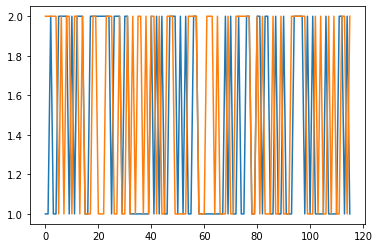

In [75]:
plt.plot(choices[500:])
plt.plot(true_categories[500:])

In [27]:
# extract the stimulus sequence for each participant
stimulus_sequence = []
for i in experiment_1.stimulus_sequence.values:
    stimulus_sequence.append(pd.read_csv(f'./stimuli/stim_list_{i}.csv', header=None).values)

In [23]:
pd.read_csv(f'./stimuli/stim_list_{i}.csv', header=None)

,0
0,3
1,3
2,3
3,3
4,3
...,...
611,7
612,7
613,10
614,10
